# Transcript instability analyses

This Jupyter notebook reproduces the expression analyses on the ILC dataset, in which we investigate whether insertions lead to reduced gene expression, pointing to transcript instability resulting from the insertions. The main reason for this analysis is to determine if transcript instability is likely to be an important factor limiting the sensitivity of IM-Fusion.

In [1]:
%reload_ext autoreload
%autoreload 2

%matplotlib inline

import sys
sys.path.append('../src')

import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

sns.set_style('white')

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

First we read the insertion and exon expression datasets. For the insertion dataset we filter insertions with support < 2, annotate insertion clonality (which we will need further on) and translate sample names to the RNA-seq ids. For the exon expression dataset, we read both gene and exon expression counts. The gene expression counts are used to calculate normalization factors (which normalize for sequencing depth differences between samples). These factors are subsequently used to normalize the exon expression counts. 

In [2]:
from imfusion.model import Insertion

# Read samples.
samples = pd.read_csv('../data/processed/sb/samples.txt', sep='\t')

# Read ShearSplink insertions.
insertions = (pd.read_csv('../data/external/shear_splink/insertions.cis.rbm.txt', 
                          dtype={'chromosome': str, 
                                 'position': int,
                                 'strand': int, 
                                 'support': int,
                                 'depth': int,
                                 'depth_unique': int}, sep='\t')
                .rename(columns={'chromosome': 'seqname'})
                .query('support >= 2'))

# Add clonality score.
insertions['clonality'] = (insertions.groupby(['sample'])
                           ['support'].transform(lambda x: x / x.max()))

# Map sample names.
name_map = dict(zip(samples['short_name'], samples['sample']))
insertions['sample'] = insertions['sample'].map(name_map)

In [3]:
from imfusion.expression.counts import read_exon_counts, estimate_size_factors

# Read gene expression.
gene_counts = (pd.read_csv('../data/processed/sb/star/expression.fc_gene.txt', 
                           sep='\t', comment='#', index_col=0)
                 .drop(['Chr', 'Start', 'End', 'Strand', 'Length'], axis=1))

gene_counts.columns = [c.split('/')[-2] for c in gene_counts.columns]

# Read exon counts.
exon_counts = read_exon_counts('../data/processed/sb/star/expression.txt')

# Normalize exon counts by size factors.
with np.errstate(divide='ignore'):
    size_factors = estimate_size_factors(gene_counts)
    exon_counts = exon_counts[gene_counts.columns] / size_factors

Next, we tally the most frequently recurring genes, which we are most interested in plotting.

In [4]:
dna_candidates = (insertions.groupby(['gene_name', 'gene_id'])
                  ['sample'].nunique().sort_values(ascending=False)
                  .reset_index(name='count'))

dna_candidates.head(n=5)

,gene_name,gene_id,count
0,Fgfr2,ENSMUSG00000030849,64
1,Trps1,ENSMUSG00000038679,56
2,Ppp1r12a,ENSMUSG00000019907,52
3,Myh9,ENSMUSG00000022443,33
4,Trp53bp2,ENSMUSG00000026510,17


Finally, we create two kinds of plots for the top 10 candidate genes. In these plots, we compares expression between samples with and without an insertion (left) and across samples with varying levels of insertion clonality (right), to determine if (clonal) insertions  result in reduced expression. Expression values were quantified using the exons before the insertion sites (after normalizing for overall differences in expression between samples), as the expression of these exons should not be affected by the insertion(s). Correlations and p-values are calculated using Spearman’s Rank correlation.

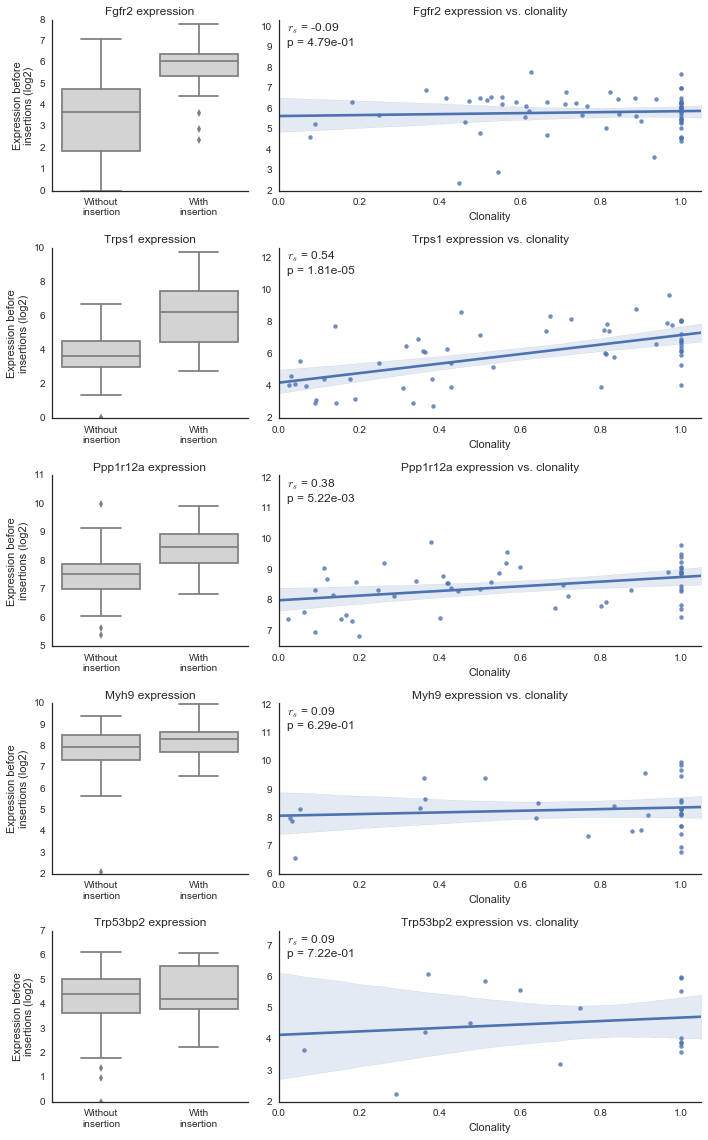

In [5]:
import matplotlib.gridspec as gridspec

from scipy.stats import spearmanr
from imfusion.expression.test import split_counts

# fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(10, 5))
def plot_expr_vs_clonality(insertions, exon_counts, gene_ids, 
                           gene_names=None, figsize=(10, 16), **kwargs):
    if gene_names is None:
        gene_names = gene_ids
        
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(len(gene_ids), 3)
    
    for i, (gene_id, gene_name) in enumerate(zip(gene_ids, gene_names)):
        _plot_for_gene(insertions, exon_counts, gene_id, gs, index=i, 
                       gene_name=gene_name, **kwargs)
        
    sns.despine()
    plt.tight_layout()
        
    return fig


def _plot_for_gene(insertions, exon_counts, gene_id, gridspec, index, 
                   gene_name=None, reg_kws=None, box_kws=None):
    
    if gene_name is None:
        gene_name = gene_id
        
    insertions = insertions.query('gene_id == {!r}'.format(gene_id))
    insertion_objs = list(Insertion.from_frame(
        insertions.assign(
            support_junction=lambda df: df.support, 
            support_spanning=0)))
    
    # Get before counts.
    before, after, _ = split_counts(exon_counts, insertion_objs, gene_id=gene_id)
    before_counts = (np.log2(before.sum() + 1)
                     .reset_index(name='before_expr')
                     .rename(columns={'index': 'sample'}))

    # Get sample clonality.
    sample_clonality = (insertions.groupby('sample')
                        ['clonality'].max()
                        .reset_index(name='clonality'))
    
    # Merge counts/clonality, add insertion status.
    data = pd.merge(before_counts, sample_clonality, on='sample', how='left')
    data['has_insertion'] = ~data['clonality'].isnull()

    # Setup axes.
    ax1 = plt.subplot(gridspec[index, 0])
    ax2 = plt.subplot(gridspec[index, 1:])
    
    # Draw boxplot.
    sns.boxplot(data=data, x='has_insertion', y='before_expr', ax=ax1, 
                color='lightgrey', **(box_kws or {}))
    
    ax1.set_xlabel('')    
    ax1.set_xticklabels(['Without\ninsertion', 'With\ninsertion'])
    ax1.set_ylabel('Expression before\ninsertions (log2)')
    ax1.set_title(gene_name + ' expression')
    
    # Draw expr. vs correlation.
    clonality_data = data.dropna(subset=['clonality'])
    sns.regplot(data=data, x='clonality', y='before_expr', 
                ax=ax2, **(reg_kws or {}))

    ax2.set_xlim(0, 1.05)
    ax2.set_ylim(None, ax2.get_ylim()[1] * 1.15)
    
    ax2.set_xlabel('Clonality')
    ax2.set_ylabel('')
    ax2.set_title(gene_name + ' expression vs. clonality')

    # Annotate with correlation.
    corr = spearmanr(clonality_data['clonality'], 
                     clonality_data['before_expr'])

    ax2.annotate(
        '$r_s$ = {:3.2f}\np = {:3.2e}'.format(corr.correlation, corr.pvalue),
        xy=(0.02, 1.0),
        xycoords='axes fraction',
        ha='left',
        va='top')
    
# Plot example for top 5 genes.
plot_expr_vs_clonality(
    insertions, exon_counts, 
    gene_ids=dna_candidates.loc[:4, 'gene_id'],
    gene_names=dna_candidates.loc[:4, 'gene_name'],
    figsize=(10, 16));

From these plots, we can see that samples with insertions do not show lower expression. Additionally, there is no (significant) negative trend between clonality and expression, indicating that clonal inesrtions do not result in lower expression. Together, this indicates that insertions do not result in transcript instability.

In [6]:
with sns.plotting_context('paper', font_scale=0.7):
    
    # Plot genes 1-5.
    fig1 = plot_expr_vs_clonality(
        insertions, exon_counts, 
        gene_ids=dna_candidates.loc[:4, 'gene_id'],
        gene_names=dna_candidates.loc[:4, 'gene_name'],
        figsize=(4.5, 7.5),
        reg_kws={'scatter_kws': {'s': 5}},
        box_kws={'linewidth': 0.75, 'fliersize': 2})
    
    fig1.savefig('../reports/supplemental/figures/fig_s7_instability_part1.pdf', bbox_inches='tight')
    plt.close(fig1)
        
    # Plot genes 5-10.
    fig2 = plot_expr_vs_clonality(
        insertions, exon_counts, 
        gene_ids=dna_candidates.loc[5:9, 'gene_id'],
        gene_names=dna_candidates.loc[5:9, 'gene_name'],
        figsize=(4.5, 7.5),
        reg_kws={'scatter_kws': {'s': 5}},
        box_kws={'linewidth': 0.75, 'fliersize': 2})
    
    fig2.savefig('../reports/supplemental/figures/fig_s7_instability_part2.pdf', bbox_inches='tight')
    plt.close(fig2)